<div style="float: left;">
    <img src="image\sl_logo.svg" alt="SL Logo" width="300" height="300">
</div>

# 2024 Samsung Lions Team Standings

KBO 삼성 라이온즈의 팬으로서, 2024년도 시즌의 유의미한 삼성 라이온즈 팀데이터를 수집하고 분석해 보았습니다.
<br>As a fan of the Samsung Lions in KBO, I have collected and analyzed significant team data from the 2024 season of the Samsung Lions.

### Objectives
- **홈/원정 선취점 시 승률 - WPCT when scoring first (Home & Away) // (진행중 / In Progress)**
- **구장별 승률 - WPCT by place // (진행중 / In Progress)**
- 5회, 7회까지 리드시 승률 - WPCT when leading after the 5th and 7th innings
- 전체 시즌/월별 승률, 팀 타율, 팀 평균 자책점 - Season/Monthly WPCT, Team AVG, Team average ERA
- 선발, 불펜 투수 평균 자책점 - Starting pitchers' and relief pitchers' average ERA

## 0. Get 2024 Match Data

In [1]:
#install kbodata package
#pip install kbodata 

#load kbo-data package
import kbodata

#Require Chrome driver -> pip install webdriver-manager

#make sure to specify the correct path to the installed Chrome driver

#select year, month, day
yyyy = 2024
#mm = mm
#dd = dd

#get the KBO match schedule for mm/dd/yyyy
#day = kbodata.get_daily_schedule(yyyy, mm, dd, r"chromedriver-win64\chromedriver.exe")

#get the KBO match schedule for mm/yyyy
#month = kbodata.get_monthly_schedule(yyyy, mm, r"chromedriver-win64\chromedriver.exe")

#get the KBO match schedule for yyyy
year = kbodata.get_yearly_schedule(yyyy, r"chromedriver-win64\chromedriver.exe")

in progress: 100%|█████████████████████████████████████████████████████████████████████| 12/12 [01:23<00:00,  6.97s/it]


In [2]:
#filter S.Lions matches in the 2024 KBO league season
sl_year = year[((year.home == "SS") | #filter S.Lions matches
               (year.away == "SS")) & 
               (~year.date.str.contains("2024030") & #filter out pre-season matches
                ~year.date.str.contains("2024031"))] 

print(sl_year.shape[0]) #total matches played in 2024
print(sl_year)

77
       status      date home away  dbheader gameid
51   finished  20240323   KT   SS         0  SSKT0
56   finished  20240324   KT   SS         0  SSKT0
58   finished  20240326   LG   SS         0  SSLG0
63   finished  20240327   LG   SS         0  SSLG0
68   finished  20240328   LG   SS         0  SSLG0
..        ...       ...  ...  ...       ...    ...
415  finished  20240615   NC   SS         0  SSNC0
421  finished  20240616   NC   SS         0  SSNC0
425  finished  20240618   SS   SK         0  SKSS0
430  finished  20240619   SS   SK         0  SKSS0
435  finished  20240620   SS   SK         0  SKSS0

[77 rows x 6 columns]


In [3]:
#2024년 KBO 경기 정보를 가져옵니다. 
#get the KBO match information for 2024.
sl_year_data = kbodata.get_game_data(sl_year, r"chromedriver-win64\chromedriver.exe")

#convert the team data to DataFrame
sl_scoreboard = kbodata.scoreboard_to_DataFrame(sl_year_data)
sl_scoreboard

in progress: 100%|█████████████████████████████████████████████████████████████████████| 77/77 [13:39<00:00, 10.64s/it]


,idx,team,result,i_1,i_2,i_3,i_4,i_5,i_6,i_7,...,day,week,home,away,dbheader,place,audience,starttime,endtime,gametime
0,20240323003,삼성,1,0,1,0,0,0,0,1,...,23,5,KT,삼성,0,수원,18700,14:00,17:19,3:19
1,20240323010,KT,-1,0,0,1,1,0,0,0,...,23,5,KT,삼성,0,수원,18700,14:00,17:19,3:19
2,20240324003,삼성,1,2,1,0,1,0,3,2,...,24,6,KT,삼성,0,수원,18700,14:00,17:17,3:17
3,20240324010,KT,-1,0,0,0,1,0,0,0,...,24,6,KT,삼성,0,수원,18700,14:00,17:17,3:17
4,20240326003,삼성,-1,0,0,0,0,0,3,0,...,26,1,LG,삼성,0,잠실,14229,18:30,21:09,2:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,20240618003,삼성,-1,2,0,0,0,0,0,1,...,18,1,삼성,SSG,0,대구,10426,18:30,22:04,3:34
142,20240619011,SSG,-1,0,0,0,1,0,1,0,...,19,2,삼성,SSG,0,대구,11488,18:30,21:45,3:15
143,20240619003,삼성,1,0,0,0,0,1,3,4,...,19,2,삼성,SSG,0,대구,11488,18:30,21:45,3:15
144,20240620011,SSG,-1,0,0,0,0,0,0,0,...,20,3,삼성,SSG,0,대구,13024,18:30,21:48,3:18


# 1. 홈/원정 선취점 시 승률 - WPCT when scoring first (Home & Away)

## 1-1. 원정경기 선취점 시 승률 - WPCT when scoring first (Away)

In [4]:
#load pandas
import pandas as pd

#filter away matches
sl_scoreboard_away = sl_scoreboard[sl_scoreboard.away == "삼성"]

def first_run_away():
    win_a = 0 #wins
    draw_a = 0 #draws
    loss_a = 0 #losses
    
    #compare each match
    for i in range(0, sl_scoreboard_away.shape[0], 2): 
        match = sl_scoreboard_away.iloc[i: i+2]
        
        #compare each inning to identify the first run team
        for j in range(3, 21):
            
            #filters when S.Lions scores first
            if (match.iloc[0][j] != 0 and (match.iloc[1][j] == 0 or match.iloc[1][j] != 0)):
                if match.iloc[0][2] == 1: #S.Lions wins 
                    win_a += 1
                elif match.iloc[0][2] == -1: #S.Lions loses
                    loss_a += 1
                else: #S.Lions draws
                    draw_a += 1
                break
                
            #filters when the opponent scores the first run    
            elif (match.iloc[0][j] == 0 and match.iloc[1][j] != 0):
                break
    
    return win_a, draw_a, loss_a
    
win_a, draw_a, loss_a = first_run_away() #get values

total_games_a = win_a + draw_a + loss_a #total away matches played when S.Lions scores first
win_per_a = (win_a * 100) / (total_games_a - draw_a) #calculate WPCT

#print result messages
result_message_a_kor = (
    f"원정경기 중 선취점을 얻은 {total_games_a}경기 중 {win_a}승 "
    f"{draw_a}무 {loss_a}패를 기록했고, "
    f"승률은 {win_per_a:.2f}%를 기록했습니다."
)

result_message_a_eng = (
    f"Out of {total_games_a} away matches with scoring first, "
    f"the team recorded {win_a}W/{draw_a}D/{loss_a}L, "
    f"resulting in a WPCT of {win_per_a:.2f}%."
)

print(result_message_a_kor)
print(result_message_a_eng)

원정경기 중 선취점을 얻은 16경기 중 13승 0무 3패를 기록했고, 승률은 81.25%를 기록했습니다.
Out of 16 away matches with scoring first, the team recorded 13W/0D/3L, resulting in a WPCT of 81.25%.


## 1-2. 홈경기 선취점 시 승률 - WPCT when scoring first (Home)

In [5]:
#filter home matches
sl_scoreboard_home = sl_scoreboard[sl_scoreboard.home == "삼성"]

def first_run_home():
    win_h = 0 #wins
    draw_h = 0 #draws
    loss_h = 0 #losses
    
    #compare each match
    for i in range(0, sl_scoreboard_home.shape[0], 2):
        match = sl_scoreboard_home.iloc[i: i+2]
        
        #compare each inning to identify the first run team
        for j in range(3, 21):
            
            #filters when S.Lions scores first
            if (match.iloc[0][j] == 0 and match.iloc[1][j] != 0):
                if match.iloc[1][2] == 1: #S.Lions wins
                    win_h += 1
                elif match.iloc[1][2] == -1: #S.Lions loses
                    loss_h += 1
                else: #S.Lions draws
                    draw_h += 1
                break
            else:
                break
                
    return win_h, draw_h, loss_h
    
win_h, draw_h, loss_h = first_run_home() #get values

total_games_h = win_h + draw_h + loss_h #calculate total home matches played when S.Lions scores first
win_per_h = (win_h * 100) / (total_games_h - draw_h) #calculate WPCT

#print result messages
result_message_h_kor = (
    f"홈경기 중 선취점을 얻은 {total_games_h}경기 중 {win_h}승 "
    f"{draw_h}무 {loss_h}패를 기록했고, "
    f"승률은 {win_per_h:.2f}%를 기록했습니다."
)

result_message_h_eng = (
    f"Out of {total_games_h} away matches with scoring first, "
    f"the team recorded {win_h}W/{draw_h}D/{loss_h}L, "
    f"resulting in a WPCT of {win_per_h:.2f}%."
)

print(result_message_h_kor)
print(result_message_h_eng)

홈경기 중 선취점을 얻은 11경기 중 10승 0무 1패를 기록했고, 승률은 90.91%를 기록했습니다.
Out of 11 away matches with scoring first, the team recorded 10W/0D/1L, resulting in a WPCT of 90.91%.


## 1-3. 홈/원정 선취점 시 승률 - WPCT when scoring first (Home & Away)

In [6]:
total_games = win_a + draw_a + loss_a + win_h + draw_h + loss_h #calculate total matches
wins_total = win_a + win_h #calculate total wins
draws_total = draw_a + draw_h #calculate total draws
losses_total = loss_a + loss_h #calculate total losses
win_per_total = (wins_total * 100) / (total_games - draw_a - draw_h) #calculate total WPCT

#print result messages
result_message_total_kor = (
    f"현재까지 선취점을 얻은 {total_games}경기 중 {wins_total}승 "
    f"{draws_total}무 {losses_total}패를 기록했고, "
    f"승률은 {win_per_total:.2f}%를 기록했습니다."
)

result_message_total_eng = (
    f"Out of {total_games} matches with scoring first, "
    f"the team recorded {wins_total}W/{draws_total}D/{losses_total}L, "
    f"resulting in a WPCT of {win_per_total:.2f}%."
)

print(result_message_total_kor)
print(result_message_total_eng)

현재까지 선취점을 얻은 27경기 중 23승 0무 4패를 기록했고, 승률은 85.19%를 기록했습니다.
Out of 27 matches with scoring first, the team recorded 23W/0D/4L, resulting in a WPCT of 85.19%.


# 2. 구장별 승률 - WPCT by Place

In [7]:
#filter SL's results
filtered_sl_scoreboard = sl_scoreboard[sl_scoreboard['idx'].str.endswith('03')] #SL = 03

#group by place and count up results and covert to table
result_table = filtered_sl_scoreboard.pivot_table(index='place', columns='result', aggfunc='size', fill_value=0)
result_table = result_table[[1, 0, -1]]
result_table.columns = ['W', 'D', 'L']

#calculate WPCT
total_games = result_table.sum(axis=1)
win_percentage = (result_table['W'] / (total_games - result_table['D']))
result_table['WPCT (%)'] = win_percentage.round(3) #round to 3 decimal places

#sort the table by WPCT in ascending order
result_table = result_table.sort_values(by='WPCT (%)', ascending=True)

#edit names in "place" column
result_table.index = result_table.index.map({
    '문학': '문학 - Munhak',
    '잠실': '잠실 - Jamsil',
    '대구': '[Home] 대구 - Daegu',
    '고척': '고척 - Gocheok',
    '광주': '광주 - Gwangju',
    '대전': '대전 - Daejeon',
    '사직': '사직 - Sajik',
    '창원': '창원 - Changwon',
    '수원': '수원 - Suwon'
})

#print table
result_table 

,W,D,L,WPCT (%)
place,,,,
문학 - Munhak,2,0,3,0.400
잠실 - Jamsil,2,1,3,0.400
창원 - Changwon,3,0,3,0.500
[Home] 대구 - Daegu,19,0,17,0.528
고척 - Gocheok,4,0,2,0.667
광주 - Gwangju,2,0,1,0.667
대전 - Daejeon,2,0,1,0.667
사직 - Sajik,4,0,2,0.667
수원 - Suwon,2,0,0,1.000


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

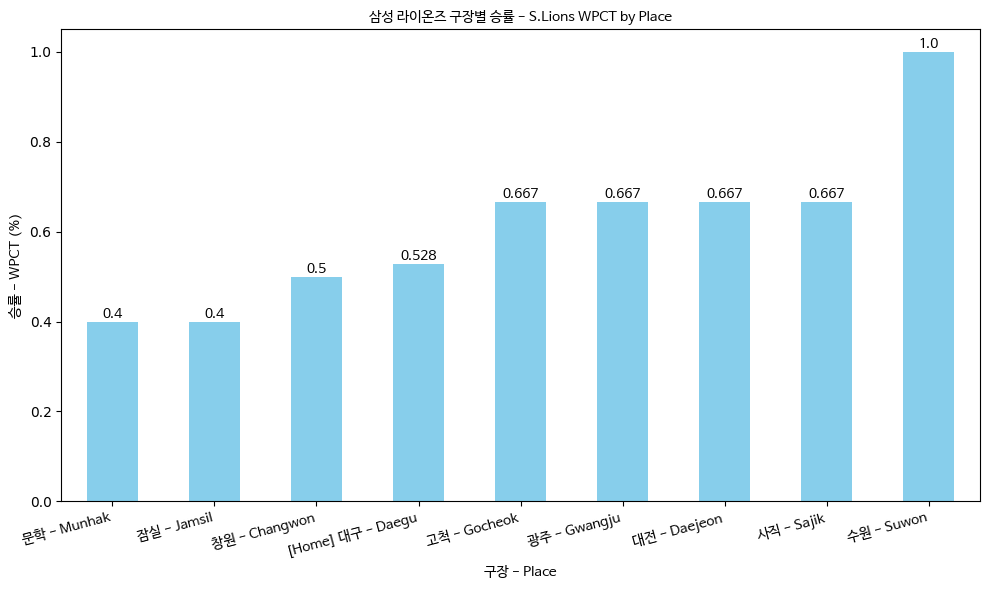

In [8]:
#load matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.figure(figsize=(10, 6))

font_path = r"C:\Users\myung\OneDrive\바탕 화면\박명근\WIX\kbo_s_lions\NanumBarunGothic.ttf"
font_prop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = font_prop.get_name()

#plot a bar chart
bars = result_table['WPCT (%)'].plot(kind='bar', color='skyblue')
plt.title('삼성 라이온즈 구장별 승률 - S.Lions WPCT by Place', fontproperties=font_prop)
plt.xlabel('구장 - Place', fontproperties=font_prop)
plt.ylabel('승률 - WPCT (%)', fontproperties=font_prop)

#add labels
for i, v in enumerate(result_table['WPCT (%)']):
    plt.text(i, v, str(v), ha='center', va='bottom', fontproperties=font_prop)

plt.xticks(range(len(result_table.index)), result_table.index, fontproperties=font_prop, rotation=15, ha='right')

plt.tight_layout()
plt.show()